In [1]:
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# load /home/zilong/Desktop/HoneycombSweeps/Data/sample_trajectory.pkl

with open('/home/zilong/Desktop/HoneycombSweeps/Data/sample_trajectory.pkl', 'rb') as f:
    data = pkl.load(f)
    

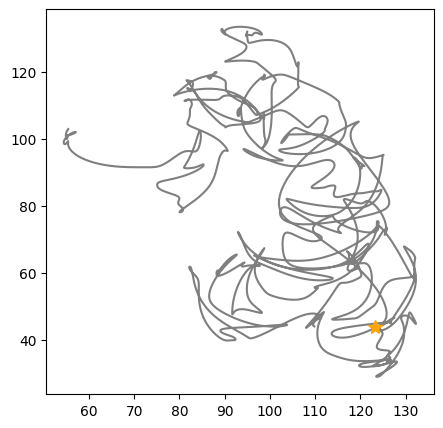

In [18]:
#plot data['pos_x'] and data['pos_y']

fig, ax = plt.subplots(1,1 , figsize=(5,5))
ax.plot(data['pos_x']*0.4, data['pos_y']*0.4, color='black', alpha=0.5)

#add goal location as a orange star
ax.plot(data['goal_location_pos_x'][0]*0.4, data['goal_location_pos_y'][0]*0.4, marker='*', color='orange', markersize=10)


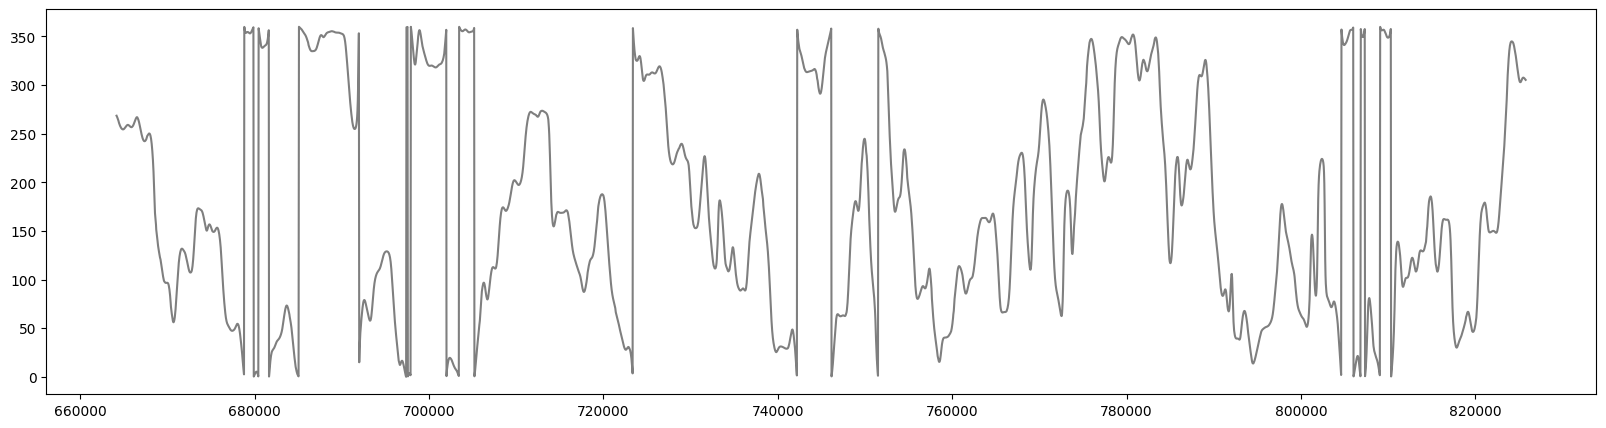

In [6]:
#data['ts'] vs data['hd']
fig, ax = plt.subplots(1,1 , figsize=(20,5))
ax.plot(data['ts'], data['hd'], color='black', alpha=0.5)



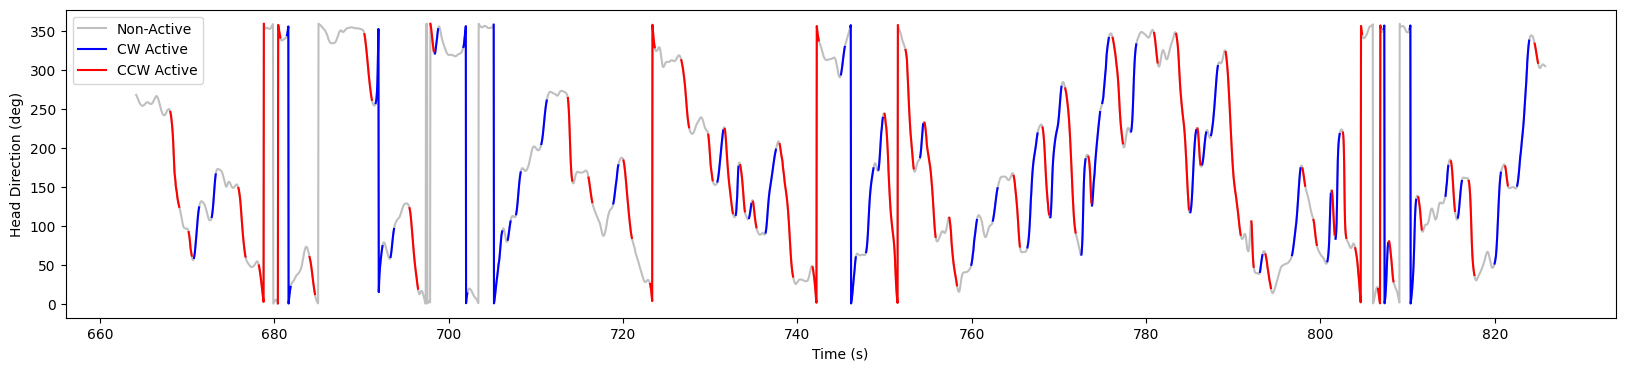

In [9]:
# Load data
ts = data['ts'].values / 1000  # Convert to seconds
hd = data['hd'].values

# Compute head direction change
hd_diff = np.diff(hd)
ts_diff = np.diff(ts)

# Normalize change to avoid wrap-around issues (-180 to 180 degrees range)
hd_diff = np.mod(hd_diff + 180, 360) - 180

# Define threshold to determine 'active rotation'
rotation_threshold = 50  # Adjust as needed
active_rotation = np.abs(hd_diff / ts_diff) > rotation_threshold

# Identify segments for CW and CCW rotations
cw_rotation = (hd_diff > 0) & active_rotation
ccw_rotation = (hd_diff < 0) & active_rotation

# Identify continuous periods of CW and CCW rotations
def get_continuous_segments(ts, mask, min_duration=0.3):
    """ Extracts continuous segments of True values in a boolean mask """
    segments = []
    start_idx = None

    for i in range(len(mask)):
        if mask[i] and start_idx is None:
            start_idx = i  # Mark start of a segment
        elif not mask[i] and start_idx is not None:
            # Check duration before storing
            if ts[i] - ts[start_idx] >= min_duration:
                segments.append((start_idx, i))
            start_idx = None

    # Check if the last segment reaches the end
    if start_idx is not None and ts[-1] - ts[start_idx] >= min_duration:
        segments.append((start_idx, len(ts) - 1))

    return segments

# Extract segments lasting at least 0.3 seconds
cw_segments = get_continuous_segments(ts[:-1], cw_rotation, min_duration=0.3)
ccw_segments = get_continuous_segments(ts[:-1], ccw_rotation, min_duration=0.3)

# Plot
fig, ax = plt.subplots(figsize=(20, 4))

# Plot non-active periods in gray
ax.plot(ts, hd, color='gray', alpha=0.5, label="Non-Active")

# Plot CW rotation segments in blue
for start, end in cw_segments:
    ax.plot(ts[start:end], hd[start:end], color='blue', label="CW Active" if start == cw_segments[0][0] else "")

# Plot CCW rotation segments in red
for start, end in ccw_segments:
    ax.plot(ts[start:end], hd[start:end], color='red', label="CCW Active" if start == ccw_segments[0][0] else "")

# Labels and legend
ax.set_xlabel("Time (s)")
ax.set_ylabel("Head Direction (deg)")
ax.legend()
plt.show()

### get the period of active scans 

In [11]:
import numpy as np

def extract_active_scans(ts, hd, rotation_threshold=50, min_duration=0.3):
    """
    Extracts periods of active scans based on head direction changes.

    Parameters:
        ts (numpy array): Time series in seconds.
        hd (numpy array): Head direction in degrees.
        rotation_threshold (float): Threshold for detecting active rotation in deg/s.
        min_duration (float): Minimum duration (seconds) for an active scan to be considered valid.

    Returns:
        cw_segments (list of tuples): [(start_idx, end_idx), ...] for clockwise rotations.
        ccw_segments (list of tuples): [(start_idx, end_idx), ...] for counterclockwise rotations.
    """
    # Compute head direction change
    hd_diff = np.diff(hd)
    ts_diff = np.diff(ts)

    # Normalize change to avoid wrap-around issues (-180 to 180 degrees range)
    hd_diff = np.mod(hd_diff + 180, 360) - 180

    # Identify active rotations
    active_rotation = np.abs(hd_diff / ts_diff) > rotation_threshold
    cw_rotation = (hd_diff > 0) & active_rotation
    ccw_rotation = (hd_diff < 0) & active_rotation

    def get_continuous_segments(mask, min_duration):
        """ Helper function to extract continuous segments of True values in a boolean mask. """
        segments = []
        start_idx = None

        for i in range(len(mask)):
            if mask[i] and start_idx is None:
                start_idx = i  # Mark start of a segment
            elif not mask[i] and start_idx is not None:
                # Check duration before storing
                if ts[i] - ts[start_idx] >= min_duration:
                    segments.append((start_idx, i))
                start_idx = None

        # Check last segment
        if start_idx is not None and ts[-1] - ts[start_idx] >= min_duration:
            segments.append((start_idx, len(ts) - 1))

        return segments

    # Extract segments as index ranges
    cw_segments = get_continuous_segments(cw_rotation, min_duration)
    ccw_segments = get_continuous_segments(ccw_rotation, min_duration)

    return cw_segments, ccw_segments


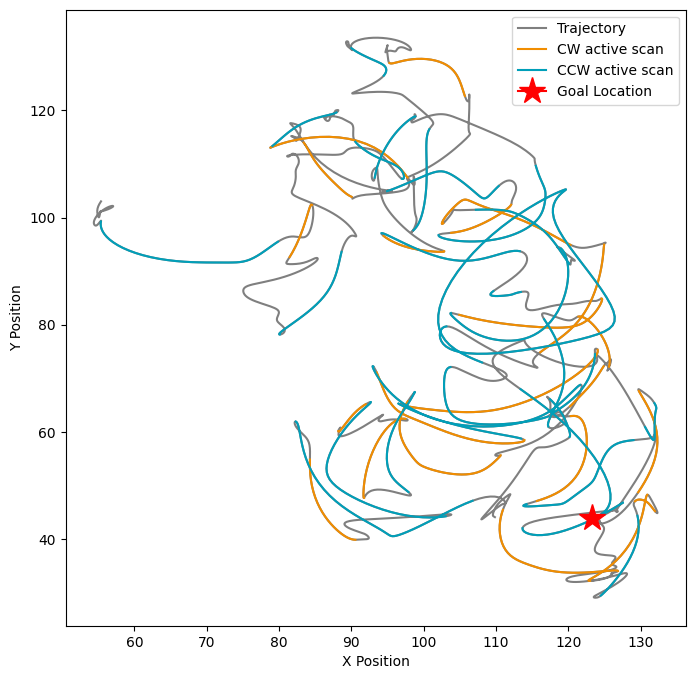

In [21]:
# Load data
ts = data['ts'].values / 1000  # Convert to seconds
hd = data['hd'].values
pos_x = data['pos_x'].values * 0.4  # Apply scaling factor
pos_y = data['pos_y'].values * 0.4

goal_x = data['goal_location_pos_x'].iloc[0] * 0.4
goal_y = data['goal_location_pos_y'].iloc[0] * 0.4

cw_scans, ccw_scans = extract_active_scans(ts, hd, rotation_threshold=20, min_duration=0.8)


# Plot trajectory
fig, ax = plt.subplots(figsize=(8, 8))

# Plot full trajectory in black (background)
ax.plot(pos_x, pos_y, color='black', alpha=0.5, label="Trajectory")

# Plot CW rotation segments in blue
cw_plotted = False  # Track if CW label has been added
for start, end in cw_scans:
    ax.plot(pos_x[start:end], pos_y[start:end], color='#F18D00', 
            label="CW active scan" if not cw_plotted else "")
    cw_plotted = True  # Ensure label is added only once

# Plot CCW rotation segments in red
ccw_plotted = False  # Track if CCW label has been added
for start, end in ccw_scans:
    ax.plot(pos_x[start:end], pos_y[start:end], color='#009FB9', 
            label="CCW active scan" if not ccw_plotted else "")
    ccw_plotted = True  # Ensure label is added only once
    
# Plot goal location as an orange star
ax.plot(goal_x, goal_y, marker='*', color='red', markersize=20, label="Goal Location")

# Labels and legend
ax.set_xlabel("X Position")
ax.set_ylabel("Y Position")
ax.legend()
plt.show()